In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import random
import typing as T
import json
import multiprocessing
import ctypes
from multiprocessing import Pool, cpu_count, Array
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from matchms.importing import load_from_mgf
from tqdm import tqdm
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.rdMolDescriptors import CalcMolFormula, CalcExactMolWt

import massspecgym.utils as utils

In [3]:
random.seed(0)

tqdm.pandas()

# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Read sets of molecules

In [5]:
df_1M = pd.read_csv('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_1M.tsv', sep='\t')
df_1M.shape, df_1M.columns

((1032456, 5),
 Index(['smiles', 'inchi_key_2D', 'inchi', 'formula', 'weight'], dtype='object'))

In [6]:
df_4M = pd.read_csv('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_4M.tsv', sep='\t')
df_4M.shape, df_4M.columns

((4175091, 4),
 Index(['smiles', 'inchikey', 'formula', 'weight'], dtype='object'))

In [7]:
df_pubchem = pd.read_csv('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_pubchem_118M.tsv', sep='\t')
# df_pubchem = pd.read_csv(utils.hugging_face_download('molecules/MassSpecGym_retrieval_molecules_pubchem.tsv'), sep='\t')
df_pubchem.shape, df_pubchem.columns

((118008573, 4),
 Index(['smiles', 'formula', 'mass', 'inchi_key_2D'], dtype='object'))

In [12]:
df_1M = df_1M.rename(columns={'weight': 'mass'})
df_4M = df_4M.rename(columns={'weight': 'mass'})

## Read spectral library

In [8]:
spectra = list(load_from_mgf('/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf'))

In [9]:
smiles = pd.Series([s.metadata['smiles'] for s in spectra])
smiles = smiles.drop_duplicates()
len(spectra), len(smiles)

(803405, 14008)

In [8]:
# df_massspecgym = pd.read_csv(utils.hugging_face_download('MassSpecGym.tsv'), sep='\t')
# smiles = df_massspecgym['smiles']
# smiles = smiles.drop_duplicates()
# len(df_massspecgym), len(smiles)

/tmp/ipykernel_248564/2379360413.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_massspecgym = pd.read_csv(utils.hugging_face_download('MassSpecGym.tsv'), sep='\t')


(233446, 32010)

## Generate retrieval candidates from molecule sets for the spectral library

In [15]:
def dedup(seq):
    """Deduplicate list while preserving order (https://stackoverflow.com/a/480227)"""
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def init(shared_smiles, shared_formula, shared_mass, shared_inchi_key_2D):
    global df_smiles, df_formula, df_mass, df_inchi_key_2d
    df_smiles = shared_smiles
    df_formula = shared_formula
    df_mass = shared_mass
    df_inchi_key_2d = shared_inchi_key_2D

def get_candidates_single(args):
    index, smiles, cand_type, max_cands = args
    candidates_single = []

    # Log the process ID
    # logging.info(f'Process ID: {os.getpid()} handling SMILES: {smiles}')

    # Add query SMILES as one of the candidates
    if not candidates_single:
        candidates_single.append(smiles)

    # Query is already saturated with candidates
    if len(candidates_single) == max_cands:
        return candidates_single

    # Find new candidates for the query
    mol = Chem.MolFromSmiles(smiles)
    inchi_key_2D = Chem.MolToInchiKey(mol).split("-")[0]
    if cand_type == 'formula':
        formula = CalcMolFormula(mol)
        new_cands = [
            df_smiles[i] for i in range(len(df_smiles))
            if df_formula[i] == formula and df_inchi_key_2d[i] != inchi_key_2D
        ]
    elif cand_type == 'mass':
        mass = CalcExactMolWt(mol)
        mass_eps = mass * 1e-6 * 10  # 10 ppm
        new_cands = [
            df_smiles[i] for i in range(len(df_smiles))
            if abs(df_mass[i] - mass) < mass_eps and df_inchi_key_2d[i] != inchi_key_2D
        ]
    else:
        raise ValueError(f'Unknown candidates type {cand_type}.')

    # Shuffle new candidates to reach a random sample if pruned in the next step
    random.shuffle(new_cands)

    # Add new candidates until the maximum number is reached
    candidates_single.extend(new_cands)
    candidates_single = dedup(candidates_single)[:max_cands]

    return candidates_single

def get_candidates_parallel(
        query_smiles: T.Iterable[str],
        df: pd.DataFrame,
        cand_type: str = 'formula',
        max_cands: int = 256,
        df_candidates: T.Optional[pd.DataFrame] = None,
        max_workers: int = cpu_count() - 2
    ) -> pd.DataFrame:
    """For query SMILES strings, find similar SMILES from the dataframe in parallel"""
    logging.info('Starting get_candidates_parallel')

    if df_candidates is None:
        df_candidates = pd.DataFrame({'smiles': query_smiles, 'cands': [[] for _ in query_smiles]})
        logging.info('Initialized df_candidates with empty candidate lists')

    # Convert DataFrame columns to numpy arrays
    df_smiles_array = df['smiles'].to_numpy()
    df_formula_array = df['formula'].fillna('').to_numpy()
    df_mass_array = df['mass'].to_numpy()
    df_inchi_key_2d_array = df['inchi_key_2D'].fillna('').to_numpy()

    # Create shared arrays not to copy df for each process (critical in the case of whole PubChem)
    shared_smiles = Array(ctypes.c_wchar_p, df_smiles_array, lock=False)
    shared_formula = Array(ctypes.c_wchar_p, df_formula_array, lock=False)
    shared_mass = Array(ctypes.c_double, df_mass_array, lock=False)
    shared_inchi_key_2D = Array(ctypes.c_wchar_p, df_inchi_key_2d_array, lock=False)

    logging.info(f'Setting up shared arrays with {max_workers} workers')
    
    with Pool(
        processes=max_workers,
        initializer=init,
        initargs=(shared_smiles, shared_formula, shared_mass, shared_inchi_key_2D)
    ) as pool:
        args = [(index, row['smiles'], cand_type, max_cands) for index, row in df_candidates.iterrows()]
        
        # Use tqdm to show the progress bar
        results = []
        for result in tqdm(pool.imap(get_candidates_single, args), total=len(args)):
            results.append(result)
        
        df_candidates['cands'] = results
        logging.info('Finished multiprocessing pool')

    logging.info('Completed get_candidates_parallel')
    return df_candidates

In [17]:
candidates = get_candidates_parallel(smiles, df_1M, cand_type='mass')
candidates['cands'].apply(len).hist(bins=100)

2025-01-15 12:12:23,289 - INFO - Starting get_candidates_parallel
2025-01-15 12:12:23,309 - INFO - Initialized df_candidates with empty candidate lists
2025-01-15 12:12:24,622 - INFO - Setting up shared arrays with 32 workers
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'init' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode

KeyboardInterrupt: 

In [18]:
if __name__ == '__main__':
    # run your parallel code
    candidates = get_candidates_parallel(smiles, df_1M, cand_type='mass', max_workers=32)

2025-01-15 12:17:15,067 - INFO - Starting get_candidates_parallel
2025-01-15 12:17:15,099 - INFO - Initialized df_candidates with empty candidate lists
2025-01-15 12:17:16,448 - INFO - Setting up shared arrays with 32 workers
Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/multiprocessing/spawn.py",

KeyboardInterrupt: 

2024-06-01 14:25:13,986 - INFO - Starting get_candidates_parallel
2024-06-01 14:25:24,337 - INFO - Setting up shared arrays with 126 workers
100%|██████████| 32010/32010 [03:17<00:00, 162.45it/s]
2024-06-01 14:29:32,864 - INFO - Finished multiprocessing pool
2024-06-01 14:29:35,278 - INFO - Completed get_candidates_parallel


<Axes: >

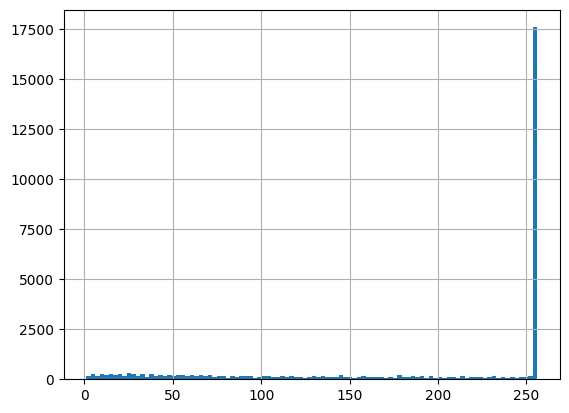

In [20]:
candidates = get_candidates_parallel(smiles, df_4M, cand_type='mass', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [21]:
candidates.to_pickle('cands_4M_mass.pkl')
# candidates = pd.read_pickle('cands_4M_mass.pkl')

2024-06-01 14:29:53,721 - INFO - Starting get_candidates_parallel


2024-06-01 14:38:46,194 - INFO - Setting up shared arrays with 126 workers
100%|██████████| 32010/32010 [1:32:05<00:00,  5.79it/s]  
2024-06-01 16:14:44,898 - INFO - Finished multiprocessing pool
2024-06-01 16:14:53,597 - INFO - Completed get_candidates_parallel


<Axes: >

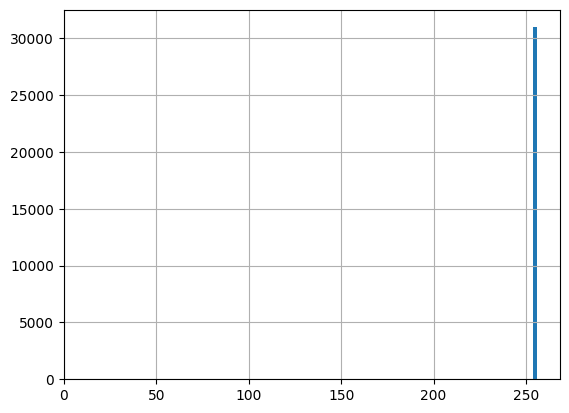

In [22]:
candidates = get_candidates_parallel(smiles, df_pubchem, cand_type='mass', df_candidates=candidates)
candidates['cands'].apply(len).hist(bins=100)

In [23]:
candidates.to_pickle('cands_pubchem_118M_mass.pkl')
# candidates = pd.read_pickle('cands_pubchem_118M_mass.pkl')

In [24]:
# Write candidates dictionary to JSON file
with open('MassSpecGymMSn_retrieval_candidates_mass.json', 'w') as json_file:
    candidates_dict = dict(zip(candidates['smiles'], candidates['cands']))
    json.dump(candidates_dict, json_file)